In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/trabajo-final-check-worthiness/check-worthiness-project
%ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1S2YTpyjEJLco8XPXsyW3F4GAELxQkz49/trabajo-final-check-worthiness/check-worthiness-project
data/  git_commands.ipynb  main.ipynb


# Dataset loading
`Using datasets in spanish language only`

>### clef2021-checkthat
>[dev & train](https://github.com/Newtral-Tech/clef2021-checkthat/tree/main)
>[testing](https://gitlab.com/checkthat_lab/clef2021-checkthat-lab/-/blob/master/task1/test-gold/subtask-1a--spanish.zip)  
>`topic_id | tweet_id | tweet_url | tweet_text | claim | check-worthiness`
>- data/clef2021-checkthat/dataset_train.csv.zip
>- data/clef2021-checkthat/dataset_dev.csv.zip
>- data/clef2021-checkthat/dataset_test_goldstandard.csv.zip



>### clef2022-checkthat-lab
>[dev dev_test train](https://gitlab.com/checkthat_lab/clef2022-checkthat-lab/clef2022-checkthat-lab/-/tree/main/task1/data/subtasks-spanish)  
>`topic | tweet_id | tweet_url | tweet_text | class_label`
>- data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_train.csv.zip
>- data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev.csv.zip
>- data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev_test.csv.zip

>### clef2023-checkthat-lab
>[dev dev_test train](https://gitlab.com/checkthat_lab/clef2023-checkthat-lab/-/tree/main/task1/data)  
>`tweet_id | tweet_url | tweet_text | class_label`
>- data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_train.csv.zip
>- data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev.csv.zip
>- data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev_test.csv.zip

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Training dataset

train_df = pd.read_csv('data/clef2021-checkthat/dataset_train.csv.zip')
train_df = train_df.drop('topic_id', axis=1)
train_df = train_df[train_df['claim'] == 1].drop('claim', axis=1) # 2495 a 952
train_df = train_df.rename(columns={'check-worthiness': 'class_label'})

aux_df = pd.read_csv('data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_train.csv.zip')
aux_df = aux_df.drop('topic', axis=1)
train_df = pd.concat([train_df, aux_df])

aux_df = pd.read_csv('data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_train.csv.zip')
aux_df['class_label'] = aux_df['class_label'].replace('No', 0).replace('Yes', 1)
train_df = pd.concat([train_df, aux_df], ignore_index=True)  # every dataframe concatenated

train_df

,tweet_id,tweet_url,tweet_text,class_label
0,1217566329823252481,https://twitter.com/user/status/12175663298232...,@tve_tve vuelve a quedar en evidencia. Desplaz...,0
1,1172059020095610881,https://twitter.com/user/status/11720590200956...,El nuevo curso escolar en #Andalucía comienza ...,0
2,1226480356955693056,https://twitter.com/user/status/12264803569556...,El PP se equivoca total y completamente excluy...,0
3,1259920819834191872,https://twitter.com/user/status/12599208198341...,Si algo define a @CruzRojaEsp es que siempre e...,0
4,1226086367710580737,https://twitter.com/user/status/12260863677105...,"Hoy @populares se ha unido a PSOE, PODEMOS y ...",0
...,...,...,...,...
13425,1447650732581310470,https://twitter.com/user/status/14476507325813...,"Las organizaciones médicas alertan de una ""inm...",0
13426,1456501355833696256,https://twitter.com/user/status/14565013558336...,82 días desde que empezó el #IFNavalacruz en #...,0
13427,1440963865848819714,https://twitter.com/user/status/14409638658488...,🌍 Valiente y coherente‼️ El presidente Pedro S...,0
13428,1446462258121428993,https://twitter.com/user/status/14464622581214...,El PP no conforme con retrasar la llegada del ...,0


In [4]:
# Dev dataset

dev_df = pd.read_csv('data/clef2021-checkthat/dataset_dev.csv.zip')
dev_df = dev_df.drop('topic_id', axis=1)
dev_df = dev_df[dev_df['claim'] == 1].drop('claim', axis=1)
dev_df = dev_df.rename(columns={'check-worthiness': 'class_label'})

aux_df = pd.read_csv('data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev.csv.zip')
aux_df = aux_df.drop('topic', axis=1)
dev_df = pd.concat([dev_df, aux_df])

aux_df = pd.read_csv('data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev.csv.zip')
aux_df['class_label'] = aux_df['class_label'].replace('No', 0).replace('Yes', 1)
dev_df = pd.concat([dev_df, aux_df], ignore_index=True)  # every dataframe concatenated

dev_df

,tweet_id,tweet_url,tweet_text,class_label
0,1227543257690918913,https://twitter.com/user/status/12275432576909...,4. La conclusión para no iniciados es clara: l...,1
1,1222917768774856707,https://twitter.com/user/status/12229177687748...,SUMA Y SIGUE\n\nTambién se ha detectado que Co...,1
2,1176096346379575296,https://twitter.com/user/status/11760963463795...,@CiudadanosCs #ThomasCook tiene en #España cer...,0
3,1224776781753978882,https://twitter.com/user/status/12247767817539...,"📢 Es insuficiente la subida del 0,9% de pensio...",0
4,1220305130324742145,https://twitter.com/user/status/12203051303247...,Que Sánchez DEPENDE del independentismo no es ...,0
...,...,...,...,...
5430,1456998178008481800,https://twitter.com/user/status/14569981780084...,Los 10 mejores cantantes de la historia del ro...,0
5431,1444601817590124544,https://twitter.com/user/status/14446018175901...,La izquierda y la 'pobreza energética' . http...,0
5432,1449465039027687427,https://twitter.com/user/status/14494650390276...,Un orgullo formar parte de la mesa del 40 cong...,0
5433,1443118096617775105,https://twitter.com/user/status/14431180966177...,Lamenta la CUP que la Mesa del Congreso ha cor...,0


In [5]:
# Test dataset

test_df = pd.read_csv('data/clef2021-checkthat/dataset_test_goldstandard.csv.zip')
test_df = test_df.drop('topic_id', axis=1)
test_df = test_df[test_df['claim'] == 1].drop('claim', axis=1)
test_df = test_df.rename(columns={'check-worthiness': 'class_label'})

aux_df = pd.read_csv('data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev_test.csv.zip')
aux_df = aux_df.drop('topic', axis=1)
test_df = pd.concat([test_df, aux_df])

aux_df = pd.read_csv('data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev_test.csv.zip')
aux_df['class_label'] = aux_df['class_label'].replace('No', 0).replace('Yes', 1)
test_df = pd.concat([test_df, aux_df], ignore_index=True)  # every dataframe concatenated

test_df

,tweet_id,tweet_url,tweet_text,class_label
0,1296128564090351616,https://twitter.com/user/status/12961285640903...,"Qué tal si ponemos el foco aquí? ¿""Por no ser ...",1
1,1260816850658775042,https://twitter.com/user/status/12608168506587...,El 75% de los créditos ICO para pymes y autóno...,1
2,1268857203366256641,https://twitter.com/user/status/12688572033662...,"Visito Torrejón de Ardoz con su alcalde, donde...",1
3,1188175222026973184,https://twitter.com/user/status/11881752220269...,"Aquí tienen a TV3, una tv que pagamos todos, c...",0
4,1219242938389102592,https://twitter.com/user/status/12192429383891...,La tragedia vuelve a sacudirnos con un crimen ...,0
...,...,...,...,...
7971,1454818788126380037,https://twitter.com/user/status/14548187881263...,"Para ser grande, se entero: nada tuyo exageres...",0
7972,1464547666487132170,https://twitter.com/user/status/14645476664871...,Las políticas de @PSOE son las de la mayoría s...,0
7973,1458749622592155648,https://twitter.com/user/status/14587496225921...,Un gobierno incompetente y que engaña a los es...,1
7974,1455926135494217729,https://twitter.com/user/status/14559261354942...,Algunas de nuestras enmiendas a los #PGE2022: ...,0


# Preprocessing



```
******************** hidden ********************
```



In [ ]:
import re
import spacy
!python -m spacy download es_core_news_lg

In [ ]:
nlp = spacy.load("es_core_news_lg")

In [ ]:
def preprocess_tweet(tweet: str) -> str:
        """Function that cleans the input text by going to:
        - remove links
        - remove usernames
        - remove special characters
        - remove numbers
        - remove stopwords
        - convert to lowercase
        - remove excessive white spaces
        Arguments:
            text (str): text to clean
            remove_stopwords (bool): whether to remove stopwords
        Returns:
            str: cleaned text
        """
        # tokenization
        doc = nlp(tweet)

        tokens = []
        for token in doc:
            if token.text.startswith("@"):  # replace all user mentions with the special token "user"
                tokens.append("USER")
            elif is_url(token.text):
                tokens.append('URL')
            elif doc[token.i - 1].text == "#":
                if is_hashtag_upper_camel_case(token.text):
                    tokens.extend(chunk.lower() for chunk in re.findall(r'[A-Z][a-z\d]+', token.text))
                else:  # not UpperCamelCase
                    tokens.append("HASHTAG")
            #    print('hashtag', token.text)
            #    if is_hashtag_upper_camel_case(token.text):
            #        tokens.append(re.findall(r'[A-Z][a-z\d]+', token.text[1:]))
            #    else:  # not UpperCamelCase
            #        tokens.append("HASHTAG")
            elif token.is_stop or not token.is_alpha:  # eliminación de stopwords y caracteres no alfabéticos
                continue
            else:
                tokens.append(token.lemma_.lower())

        # replace all user mentions with the special token "user"
        #tokens = [re.sub(r'@\w+', 'user', token.text) for token in doc]

        # splitting hashtags into separate words based on UpperCamelCase 
        #tokens = [re.sub(r'#[A-Z][a-z\d]+', lambda hashtag: ' '.join(re.findall('[A-Z][a-z\d]*', hashtag.group())), tweet) for token in tokens]

        # lemmatization, case conversion, eliminación de stopwords y caracteres no alfabéticos
        #tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]

        return tokens

In [ ]:
train_df.head()

In [ ]:
train_df["cleaned"] = train_df['tweet_text'].apply(
    lambda x: preprocess_tweet(x)
)

In [ ]:
test_df["cleaned"] = test_df['tweet_text'].apply(
    lambda x: preprocess_tweet(x)
)

In [ ]:
print(train_df.iloc[3].tweet_text, '\n')
train_df.iloc[3].cleaned

In [ ]:
print(train_df.iloc[1].tweet_text, '\n')
train_df.iloc[1].cleaned

In [ ]:
print(train_df.iloc[6].tweet_text, '\n')
train_df.iloc[6].cleaned

In [ ]:
print(test_df.iloc[10].tweet_text, '\n')
test_df.iloc[10].cleaned

In [ ]:
train_df.head()

In [ ]:
test_df.head()

# Embeddings pruebas



```
******************** hidden ********************
```



## Word2vec

In [6]:
from gensim.models import Word2Vec

### Training

In [ ]:
texts = train_df['cleaned'].tolist() + test_df['cleaned'].tolist()

*   vectors_size : defines the dimensions of our vector space.
*   min_count: Words below the min_count frequency are removed from the vocabulary before training.
*   window: maximum distance between the current and the expected word within a sentence.
*   sg: defines the training algorithm. 0 = CBOW (continuous bag of words), 1 = Skip-Gram.

In [ ]:
feature_size = 10  # Word vector dimensionality. El original es 100, acá lo achicamos.
min_word_count = 1  # Minimum word count
window_context = 30  # Context window size
sample = 1e-3 # Downsample setting for frequent words
sg = 1  # Training algorithm: 1 for skip-gram; otherwise CBOW.

# w2v_model = Word2Vec(
#     sentences=texts,
#     vector_size=feature_size,
#     min_count=min_word_count,
#     window=window_context,
#     sample=sample,
#     sg=sg,
#     epochs=50  # iterations
# )

In [ ]:
w2v_model.wv['eliminar']

In [ ]:
w2v_model.wv.most_similar(positive=['funcionario'], topn=3)

In [ ]:
from pprint import pprint
# view similar words based on gensim's model 
similar_words = {
    search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
    for search_term in ['enfermedad', 'pandemia', 'funcionario', 'política', 'economía']
}
pprint(similar_words)

In [ ]:
print(type(w2v_model.wv[train_df['cleaned'].iloc[3][0]]))
print(w2v_model.wv[train_df['cleaned'].iloc[3][0]])
pd.DataFrame([w2v_model.wv[word] for word in train_df['cleaned'].iloc[3]])

### Visualization

In [ ]:
from sklearn.manifold import TSNE
def reduce_dimensions(model):
    num_components = 2  # number of dimensions to keep after compression

    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    # apply TSNE 
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualizzazione embedding con TSNE")
    fig.show()
    return fig


#x_vals, y_vals, labels = reduce_dimensions(w2v_model)

#plot = plot_embeddings(x_vals, y_vals, labels)

# Dataframes to csv

In [7]:
# Export to csv
train_df.to_csv('data/train.csv', index=False)
dev_df.to_csv('data/dev.csv', index=False)
test_df.to_csv('data/test.csv', index=False)
del aux_df
del train_df
del dev_df
del test_df

# Pipeline transformers

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

## PreprocessingTransformer

In [9]:
import re
import spacy
!python -m spacy download es_core_news_lg

2023-06-09 00:50:51.155558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [10]:
nlp = spacy.load("es_core_news_lg")

In [14]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_stats = {'USER': 0, 'URL': 0, 'HASHTAG': 0, 'ucc_processed_hashtags': 0, 'lemmatized': 0}
    
    def fit(self,X,y=None):
        return self
    
    def inverse_transform(self, X):
        return []

    def is_hashtag_upper_camel_case(self, hashtag: str) -> bool:
        pattern = r'[A-Z][a-zA-Z\d]*'
        return re.match(pattern, hashtag) is not None and hashtag != hashtag.upper()

    def is_url(self, text: str) -> str:
        return re.match(r'https?://\S+', text) is not None

    def preprocess_tweet(self, tweet: str) -> str:
        """Function that cleans the tweet text by going to:
        - replace URLs for the special token URL
        - replace usernames for the special token USER
        - remove special characters
        - remove numbers
        - remove stopwords
        - convert to lowercase
        - remove excessive white spaces
        """
        # tokenization
        doc = nlp(tweet)

        tokens = []
        for token in doc:
            if token.text.startswith("@"):  # replace all user mentions with the special token "user"
                tokens.append("USER")
                self.feature_stats['USER'] += 1
            elif self.is_url(token.text):
                tokens.append('URL')
                self.feature_stats['URL'] += 1
            elif doc[token.i - 1].text == "#":
                if self.is_hashtag_upper_camel_case(token.text):
                    # splitting hashtags into separate words based on UpperCamelCase
                    tokens.extend(chunk.lower() for chunk in re.findall(r'[A-Z][a-z\d]+', token.text))
                    self.feature_stats['ucc_processed_hashtags'] += 1
                else:  # not UpperCamelCase
                    tokens.append("HASHTAG")
                    self.feature_stats['HASHTAG'] += 1
            elif token.is_stop or not token.is_alpha:  # eliminación de stopwords y caracteres no alfabéticos
                continue
            else:
                tokens.append(token.lemma_.lower())  # lemmatization, case conversion
                self.feature_stats['lemmatized'] += 1

        return tokens

    def transform(self,X):
        '''Cada row tendrá una lista con todas las features del respectivo tweet'''
        to_return = pd.Series([self.preprocess_tweet(tweet) for tweet in X])
        print(self.feature_stats)
        return to_return


## Word2VecTransformer

In [12]:
from gensim.models import Word2Vec

In [15]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_size=300, window_context=30, min_word_count=1, sample=1e-3, epochs=50, word_postag_tuple=True):
        self.model = None
        self.feature_size = feature_size
        self.window_context = window_context
        self.min_word_count = min_word_count
        self.sample = sample
        self.epochs = epochs
        self.words_stats = {'present': 0, 'not_present': 0}

    def fit(self, X, y=None):
        if self.model is None:
            print('training embedding model...')
            self.model = Word2Vec(
                                    sentences=X, 
                                    vector_size=self.feature_size,
                                    window=self.window_context, 
                                    min_count=self.min_word_count,
                                    sample=self.sample, 
                                    epochs=self.epochs
                            )
            print('training finished.')
        else:
            print('embedding model already fitted.')

        return self

    def average_word_vectors(self, words):
        feature_vector = np.zeros((self.feature_size,),dtype="float64")
        nwords = 0.
        for word in words:
            if word in self.model.wv:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, self.model.wv[word])
                self.words_stats['present'] += 1
            else:
                # print('Word not found in model', word)
                self.words_stats['not_present'] += 1
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector

    def transform(self, X):
        '''
        Cada row corresponderá a un tweet, y c/u de las feature_size columnas
        será una dimensión del vector (promediado de todas las palabras)
        que representa al tweet entero
        '''
        to_return = pd.DataFrame([self.average_word_vectors(tweet_features) for tweet_features in X])
        print(self.words_stats, '\n')
        return to_return

# Baselines

In [16]:
from IPython.display import display, Markdown

In [17]:
def generate_show_md_table(tabla):
    tabla_md = "|".join(tabla[0]) + "\n" + "|".join(["---"] * len(tabla[0])) + "\n" + "\n".join(["|".join(map(str, fila)) for fila in tabla[1:]])
    display(Markdown(tabla_md))

## Generic metrics

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef

In [19]:
def generate_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )
    disp.plot(cmap='Blues')
    plt.show()

In [95]:
def run_metrics(y_true, y_pred, classes):
    generate_confusion_matrix(y_true, y_pred, classes)
    print('\n')

    metrics_results = {
        'precision': precision_score(y_true, y_pred),  # default=binary  # tp / (tp + fp)
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred),  # default=binary  # tp / (tp + fn)
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred),  # es default=binary  # 2 * (precision * recall) / (precision + recall)
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),  # 2 * (precision * recall) / (precision + recall)
        'accuracy': accuracy_score(y_true, y_pred),  # (tp + tn) / (tp + fp + tn + fn)
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),  # 1/2 [tp/(tp+fn) + tn/(tn+fp)]
        'mcc [-1,1]': matthews_corrcoef(y_true, y_pred)  # Matthews correlation coefficient  # (tp*tn-fp*fn)/[(tp+fp)(tp+fn)(tn+fp)(fn+fn)]^1/2
    }

    tabla = [
        metrics_results.keys(),
        metrics_results.values()
    ]
    
    generate_show_md_table(tabla)

    metrics_results = {key: str(value) for key, value in metrics_results.items()}
    return metrics_results

## Generic baseline

In [74]:
from collections import OrderedDict

final_results = OrderedDict()
final_results = {}

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [32]:
def run_baseline(pipeline, data_fpath, test_fpath, results_fpath, model_name):
    '''Works for every pipeline (or classifier) received by parameter.'''
    train_df = pd.read_csv(data_fpath)
    test_df = pd.read_csv(test_fpath)

    pipeline.fit(train_df['tweet_text'], train_df['class_label'])

    with open(results_fpath, "w") as results_file:
        if model_name == 'ngram_w2v':  # agrego para word2vec
            pipeline.named_steps['generate_embeddings'].fit(test_df['tweet_text'])
        predicted = pipeline.predict(test_df['tweet_text'])
        results_file.write("tweet_id\tclass_label\trun_id\n")

        for i, line in test_df.iterrows():
            label = predicted[i]
            results_file.write("{}\t{}\t{}\n".format(line["tweet_id"], label, model_name))

    final_results[model_name] = run_metrics(test_df['class_label'], predicted, pipeline.classes_)

## Random

In [75]:
from sklearn.dummy import DummyClassifier

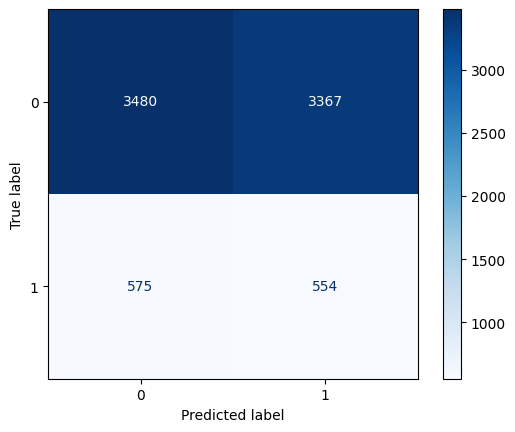

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.1412904871206325|0.7567214984235856|0.49069973427812225|0.5057673019057171|0.2194059405940594|0.5791043887505298|0.5057673019057172|0.49947576169141983|-0.0007310751699104152

In [96]:
run_baseline(
    pipeline=DummyClassifier(strategy="uniform", random_state=44),
    data_fpath='data/test.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_random.csv',
    model_name='random'
)

## Majority

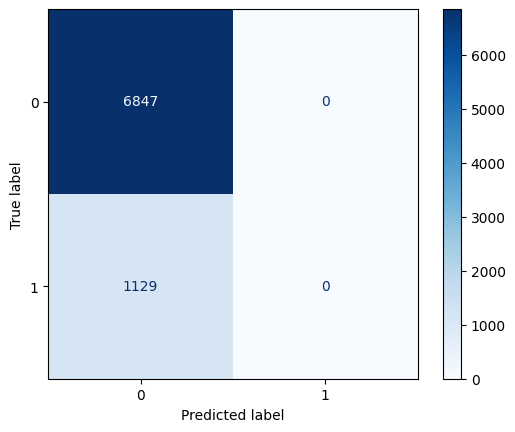

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.0|0.7369370052232928|0.0|0.8584503510531595|0.0|0.7930661207125391|0.8584503510531595|0.5|0.0

In [97]:
run_baseline(
    pipeline=DummyClassifier(strategy="most_frequent"),
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_majority.csv',
    model_name='majority'
)

## SVC

### w/ vectors

In [36]:
from sklearn.pipeline import Pipeline

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

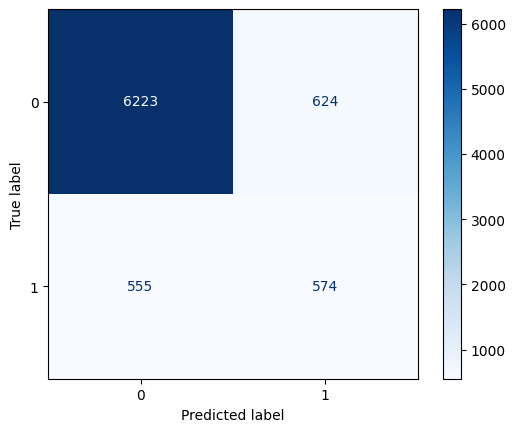

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.4791318864774624|0.855979187952402|0.508414526129318|0.8521815446339017|0.4933390631714654|0.853998801971216|0.8521815446339017|0.7086398612828568|0.40714136148237373

In [98]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams 
    ('clf', SVC(C=1, gamma='scale', kernel='linear', random_state=0))
])
run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_svc_tfidf.csv',
    model_name='svc_tfidf'
)

### w/ embeddings

#### Word2vec

{'USER': 9860, 'URL': 13285, 'HASHTAG': 1856, 'ucc_processed_hashtags': 5455, 'lemmatized': 190424}
training embedding model...
training finished.
{'present': 226455, 'not_present': 0} 

{'USER': 15403, 'URL': 20897, 'HASHTAG': 3113, 'ucc_processed_hashtags': 8150, 'lemmatized': 289438}
{'present': 337685, 'not_present': 7705} 



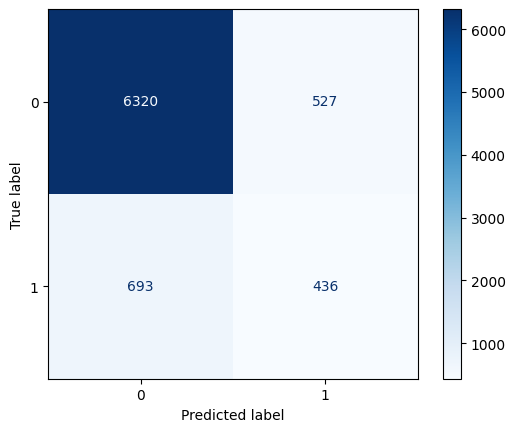

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.45275181723779856|0.8377081667441352|0.3861824623560673|0.8470411233701103|0.4168260038240918|0.8418884747521709|0.8470411233701103|0.6546072235834667|0.3308200696768988

In [99]:
pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('generate_embeddings', Word2VecTransformer()),
    ('clf', SVC(C=1, gamma='scale', kernel='linear', random_state=0))
])

run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_svc_w2vec.csv',
    model_name='svc_w2vec'
)


##### debug



```
******************** hidden ********************
```



In [53]:
preprocessed = PreprocessingTransformer().fit_transform(train_df['tweet_text'])

{'USER': 9860, 'URL': 13285, 'HASHTAG': 1856, 'ucc_processed_hashtags': 5455, 'lemmatized': 190424}


In [54]:
preprocessed

0        [USER, volver, quedar, evidencia, desplazar, m...
1        [curso, escolar, andaluc, comenzar, presupuest...
2        [pp, equivocar, completamente, excluir, vox, m...
3        [definir, USER, necesitar, HASHTAG, movilizar,...
4        [USER, unir, psoe, erc, pacto, cárcel, lledone...
                               ...                        
13425    [organización, médico, alertar, inminente, cat...
13426    [empezar, navalacruz, HASHTAG, USER, anunciar,...
13427    [valiente, presidente, pedro, sánchez, mostrar...
13428    [pp, conformar, retrasar, llegada, ave, extrem...
13429    [razón, congreso, investigar, negocio, oscuro,...
Length: 13430, dtype: object

In [66]:
embeddings = Word2VecTransformer().fit_transform(X=preprocessed)

training embedding model...
training finished.
{'present': 226455, 'not_present': 0}


In [70]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.136143,1.198859,0.102844,0.670876,0.608562,-0.610436,0.658396,0.976333,-0.353578,-0.041321,...,-0.594645,-0.075685,-0.056387,-0.301623,0.273163,-0.024309,-0.054861,-0.111693,0.374118,-0.317363
1,1.009364,0.643523,-0.449479,-0.356971,1.246303,-0.427633,0.019305,0.748654,-0.248010,-0.088318,...,0.221197,-0.095235,0.260573,-0.348216,-0.343339,0.197810,-0.852394,0.256904,-0.247956,-0.873084
2,1.073062,0.676108,0.231484,0.104979,0.493429,-0.181580,-0.988432,0.177865,-0.816469,-0.334149,...,-0.315999,0.436569,-0.339837,0.547689,-0.431410,0.810997,-0.609445,0.964734,1.048878,-1.184155
3,0.397703,-0.021286,0.212271,0.163830,0.360934,-0.090307,-0.103695,0.486036,-0.576798,-0.799049,...,0.131756,0.499056,-0.274106,0.078978,0.118708,0.587428,0.079046,0.011708,0.310015,-0.203577
4,0.412710,0.305507,-0.105287,0.509055,-0.831424,-0.363297,0.218034,0.125422,0.161145,0.303121,...,-0.397113,-0.369610,0.243512,0.036240,0.227276,0.933431,-0.352032,0.130725,0.643481,-0.813416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13425,0.682195,-0.433000,1.080944,0.299886,-0.073971,0.024694,0.584428,0.677398,0.702821,-0.045219,...,-0.617977,-0.009176,-0.149993,-0.060105,0.098064,-0.238124,-0.616518,0.340738,0.891965,-0.089649
13426,1.271502,-0.441212,-0.521667,-0.640687,0.972987,0.233272,0.234564,1.463010,-0.440728,-0.156510,...,-0.149927,0.539346,1.218293,0.842236,0.221457,0.253545,-0.417812,0.175912,-0.090960,0.679411
13427,0.799352,-0.047485,0.497830,0.404130,0.730670,0.027502,0.178912,0.960028,0.265506,-0.653293,...,-0.028366,-0.053193,0.001178,-0.044444,0.292973,0.690024,-0.117678,0.514782,0.248916,-0.131251
13428,1.203742,0.288112,0.210629,0.334030,0.314712,0.077216,-0.293929,0.600684,0.204571,-0.012171,...,-0.499748,0.389335,0.160480,0.335027,-0.159109,-0.102094,-0.282727,0.403959,0.930243,-0.756129


In [71]:
clf = SVC(C=1, gamma='scale', kernel='linear', random_state=0)

In [72]:
clf.fit(embeddings, train_df['class_label'])

SVC(C=1, kernel='linear', random_state=0)

## Ejemplo Tfidf



```
******************** hidden ********************
```



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = [
    'Este es el primer documento.',
    'Este documento es el segundo documento.',
    'Y este es el tercero.',
    'Es este el primer documento?',
    'El primer documento es asi loco',
    'Este documento es el ultimo, es para ser leido por los verdaderos inteligentes de la clase'
]

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))

In [ ]:
X = vectorizer.fit_transform(corpus)  # matrix of (n_samples, n_features)

In [ ]:
X

<6x20 sparse matrix of type '<class 'numpy.float64'>'
	with 40 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape  # 6 sentences, 20 features

(6, 20)

In [ ]:
vectorizer.get_feature_names_out()

array(['asi', 'clase', 'de', 'documento', 'el', 'es', 'este',
       'inteligentes', 'la', 'leido', 'loco', 'los', 'para', 'por',
       'primer', 'segundo', 'ser', 'tercero', 'ultimo', 'verdaderos'],
      dtype=object)

## Naive Bayes

### w/ vectors

In [45]:
from sklearn.naive_bayes import MultinomialNB

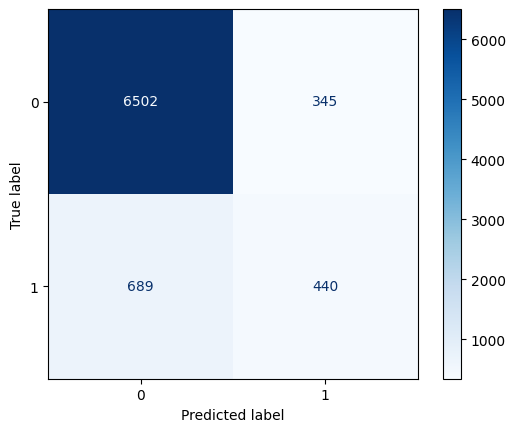

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.5605095541401274|0.85553853756574|0.38972542072630645|0.8703610832497493|0.4597701149425287|0.8602995863771404|0.8703610832497493|0.6696691949549453|0.3971007040151088

In [100]:
pipeline = Pipeline([
    ('tdidf_vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams 
    ('clf', MultinomialNB())
])
run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_bayes_tfidf.csv',
    model_name='bayes_tfidf'
)

### w/ embeddings

#### Word2vec

In [47]:
from sklearn.preprocessing import MinMaxScaler

{'USER': 9860, 'URL': 13285, 'HASHTAG': 1856, 'ucc_processed_hashtags': 5455, 'lemmatized': 190424}
training embedding model...
training finished.
{'present': 226455, 'not_present': 0} 

{'USER': 15403, 'URL': 20897, 'HASHTAG': 3113, 'ucc_processed_hashtags': 8150, 'lemmatized': 289438}
{'present': 337685, 'not_present': 7705} 



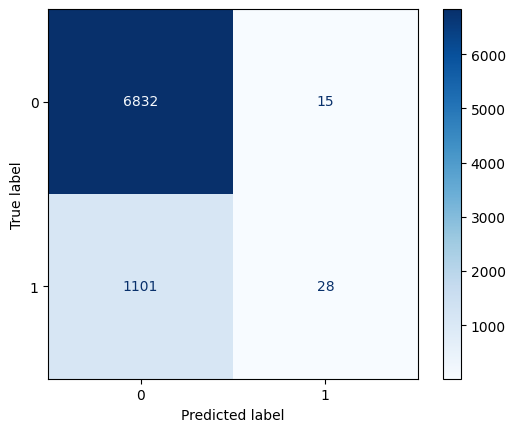

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.6511627906976745|0.8314801712999306|0.024800708591674048|0.8600802407221665|0.04778156996587031|0.8003944249954184|0.8600802407221665|0.5113049840606976|0.10763267401622606

In [101]:
# agrego MinMaxScaler antes de clf para escalar al rango [0, 1]
# y evitar los negativos

pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('word2vec', Word2VecTransformer()),
    ('scaler', MinMaxScaler()),
    ('clf', MultinomialNB())
])


run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_bayes_w2vec.csv',
    model_name='bayes_w2vec'
)

## Random Forest

### w/ vectors

In [49]:
from sklearn.ensemble import RandomForestClassifier

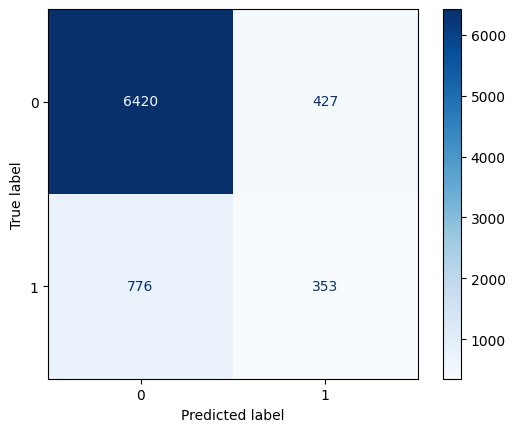

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.45256410256410257|0.8299373401164426|0.312666076173605|0.849172517552658|0.36982713462545835|0.8372597112689869|0.849172517552658|0.6251514987264988|0.29374488074804517

In [102]:
pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams 
    ('clf', RandomForestClassifier())
])
run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_random_forest_tfidf.csv',
    model_name='random_forest_tfidf'
)

### w/ embeddings

#### Word2vec

{'USER': 9860, 'URL': 13285, 'HASHTAG': 1856, 'ucc_processed_hashtags': 5455, 'lemmatized': 190424}
training embedding model...
training finished.
{'present': 226455, 'not_present': 0} 

{'USER': 15403, 'URL': 20897, 'HASHTAG': 3113, 'ucc_processed_hashtags': 8150, 'lemmatized': 289438}
{'present': 337685, 'not_present': 7705} 



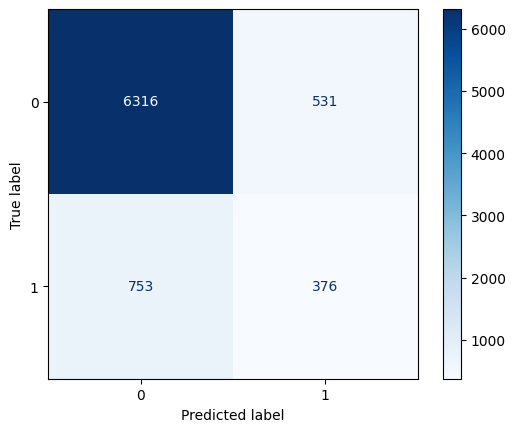

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.4145534729878721|0.8256868892702011|0.3330380868024801|0.8390170511534604|0.36935166994106094|0.8315245450720324|0.8390170511534604|0.6277429370773026|0.28053134470304675

In [103]:
pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('word2vec', Word2VecTransformer()),
    ('clf', RandomForestClassifier())
])
run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_random_forest_w2vec.csv',
    model_name='random_forest_w2vec'
)

## Logistic Regression

### w/ vectors

In [53]:
from sklearn.linear_model import LogisticRegression

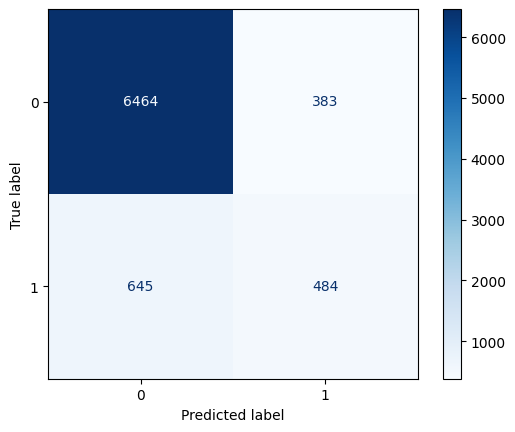

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.558246828143022|0.8595827413266035|0.4286979627989371|0.8711133400200601|0.4849699398797595|0.8638641589626828|0.8711133400200601|0.6863805280622406|0.4174590328013895

In [104]:
pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams 
    ('clf', LogisticRegression())
])
run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_logistic_regression_tfidf.csv',
    model_name='logistic_regression_tfidf'
)

### w/ embeddings

#### Word2vec

{'USER': 9860, 'URL': 13285, 'HASHTAG': 1856, 'ucc_processed_hashtags': 5455, 'lemmatized': 190424}
training embedding model...
training finished.
{'present': 226455, 'not_present': 0} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'USER': 15403, 'URL': 20897, 'HASHTAG': 3113, 'ucc_processed_hashtags': 8150, 'lemmatized': 289438}
{'present': 337685, 'not_present': 7705} 



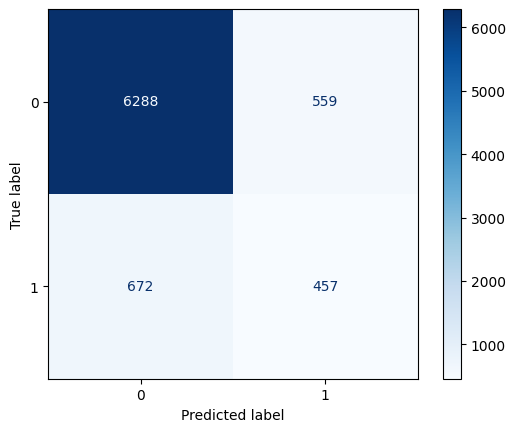

precision|precision_weighted|recall|recall_weighted|f1|f1_weighted|accuracy|balanced_accuracy|mcc [-1,1]
---|---|---|---|---|---|---|---|---
0.4498031496062992|0.8392349674941196|0.40478299379982285|0.8456619859578737|0.4261072261072261|0.8422282430837428|0.8456619859578737|0.6615706994703803|0.3378611546237097

In [105]:
pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('word2vec', Word2VecTransformer()),
    ('clf', LogisticRegression())
])
run_baseline(
    pipeline=pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    results_fpath='data/results_logistic_regression_w2vec.csv',
    model_name='logistic_regression_w2v'
)

# Final results to csv

In [108]:
#metrics_names = ['Precision', 'Precision weighted', 'Recall', 'Recall weighed', 'f1', 'f1 weighted', 'Accuracy', 'Balanced accuracy', 'MCC [-1, 1]']
metrics_names = ['precision', 'precision_weighted', 'recall', 'recall_weighted', 'f1', 'f1_weighted', 'accuracy', 'balanced_accuracy', 'mcc [-1,1]']
header = '\t' + '\t'.join(metrics_names) + '\n'

with open('data/final_results.csv', "w") as final_results_file:
    final_results_file.write(header)

    for model, metrics in final_results.items():
        line = model + '\t' + '\t'.join(metrics.values()) + '\n'
        final_results_file.write(line)
